In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Vamos a leer, visualizar y limpiar para ver quienes han tenido mayor influencia en desarrollo y quienes son expertos.

Los datasets que se van a usar son:

1. pulls_2011-2013.csv contains the basic information about the pull requests, and spans from the end of 2011 up to (but not including) 2014.
2. pulls_2014-2018.csv contains identical information, and spans from 2014 up to 2018.
3. pull_files.csv contains the files that were modified by each pull request.

In [2]:
# Loading in the data
pulls_one = pd.read_csv('datasets/pulls_2011-2013.csv')
pulls_two = pd.read_csv('datasets/pulls_2014-2018.csv')
pull_files = pd.read_csv('datasets/pull_files.csv')

In [3]:
print( pulls_one.head(2), '\n', pulls_one.shape, '\n')
print( pulls_two.head(2), '\n', pulls_two.shape, '\n')
print( pull_files.head(2), '\n', pull_files.shape, '\n')

        pid         user                  date
0  11166973  VladimirNik  2013-12-31T23:10:55Z
1  11161892      Ichoran  2013-12-31T16:55:47Z 
 (3296, 3) 

         pid      user                  date
0  163314316    hrhino  2018-01-16T23:29:16Z
1  163061502  joroKr21  2018-01-15T23:44:52Z 
 (2904, 3) 

         pid                              file
0  163314316   test/files/pos/t5638/Among.java
1  163314316  test/files/pos/t5638/Usage.scala 
 (85588, 2) 



Ahora que sabemos qué tienen los datasets vamos a unir los df pulls one y two y convertiremos la columna "date" en datetime para que en el futuro próximo podamos llamar por meses, días o años.

In [4]:
# Append pulls_one to pulls_two
pulls = pulls_one.append(pulls_two)

# Convert the date for the pulls object
pulls['date'] = pd.to_datetime(pulls['date'], utc = True)

In [5]:
pull_files['pid'].value_counts()

8771412     300
5291974     300
5524603     300
75544664    300
1148013     300
           ... 
4841616       1
4845973       1
81733499      1
4874168       1
547003        1
Name: pid, Length: 6179, dtype: int64

Ahora podemos hacer merge entre los dos data frames. La razón para hacer esto es que si se dan cuenta en el "pid" de todos los datasets, tienene en común varios, el que recién unimos contiene usuarios y fechas y pull_files contiene los archivos que ha utilizado ese PersonID. Si hacemos merge podemos ampliar la info y tenerla más concreta en un solo lugar (df).

In [6]:
# Merge the two DataFrames
data = pulls.merge(pull_files, on = 'pid')
data.head(2)

,pid,user,date,file
0,11166973,VladimirNik,2013-12-31 23:10:55+00:00,src/reflect/scala/reflect/api/Printers.scala
1,11166973,VladimirNik,2013-12-31 23:10:55+00:00,src/reflect/scala/reflect/internal/Printers.scala


Veamos cómo se distribuye la cantidad de commits durante los años

<AxesSubplot:xlabel='year'>

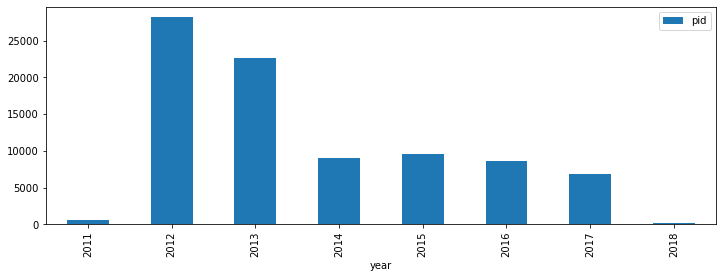

In [7]:
# Create a column that will store the month
data['month'] = data['date'].dt.month

# Create a column that will store the year
data['year'] = data['date'].dt.year

# Group by the month and year and count the pull requests
# counts = data.groupby(['month', 'year']).agg({'pid':'count'}) # mes y año
counts = data.groupby(['year']).agg({'pid':'count'})   # solo año

# Plot the results
counts.plot(kind='bar', figsize = (12,4))

Ahora veamos quienes han contribuido más al proyecto

<AxesSubplot:xlabel='user'>

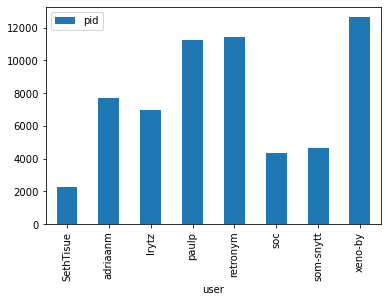

In [8]:
# Group by the submitter
by_user = data.groupby('user').agg({'pid':'count'})
# Plot the histogram
# by_user.plot(kind = 'hist') # DataCamp suguiere esto pero no le encuentro el sentifo
by_user[by_user.pid>2000].plot(kind = 'bar')

In [9]:
by_user.shape

(464, 1)

Vemos que de 464 usuarios solo 8 han tenido mayor contribuciones en el proyecto.

Veamos ahora los 10 últimos pull requests.

In [10]:
# Identify the last 10 pull requests
last_10 = pulls.sort_values('date', ascending = False)[0:10]

# Join the two data sets
joined_pr = last_10.merge(pull_files, on = 'pid')

# Identify the unique files
files = set(joined_pr['file'].unique())

# Print the results
files

{'LICENSE',
 'doc/LICENSE.md',
 'doc/License.rtf',
 'project/VersionUtil.scala',
 'src/compiler/scala/reflect/reify/phases/Calculate.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/BCodeHelpers.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/PostProcessor.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/analysis/BackendUtils.scala',
 'src/compiler/scala/tools/nsc/profile/AsyncHelper.scala',
 'src/compiler/scala/tools/nsc/profile/Profiler.scala',
 'src/compiler/scala/tools/nsc/symtab/classfile/ClassfileParser.scala',
 'src/compiler/scala/tools/nsc/typechecker/Contexts.scala',
 'src/library/scala/Predef.scala',
 'src/library/scala/concurrent/Lock.scala',
 'src/library/scala/util/Properties.scala',
 'src/reflect/scala/reflect/internal/pickling/ByteCodecs.scala',
 'src/reflect/scala/reflect/internal/tpe/GlbLubs.scala',
 'src/scaladoc/scala/tools/nsc/doc/html/page/Entity.scala',
 'src/scalap/decoder.properties',
 'test/files/neg/leibniz-liskov.check',
 'test/files/neg/leibniz-liskov

Escogiendo un archivo, veamos quién hizo más pull request a este archivo.

In [11]:
# This is the file we are interested in:
file = 'src/compiler/scala/tools/nsc/backend/jvm/BCodeHelpers.scala'

# Identify the commits that changed the file
file_pr = pull_files[pull_files['file']==file]

# Count the number of changes made by each developer
pulls_file = pd.merge(file_pr, pulls[['pid','user']], on='pid')
author_counts = pulls_file.groupby('user').agg({'pid':'count'})

# Print the top 3 developers
print(set(author_counts.nlargest(3, 'pid').index))

{'adriaanm', 'lrytz', 'retronym'}


Ahora veamos qué tanto contribuyeron ellos tres en todo el proyecto

<AxesSubplot:xlabel='date'>

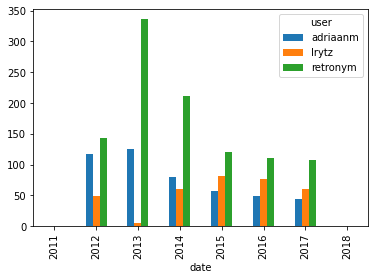

In [12]:
# The developers we are interested in
authors = ['retronym', 'adriaanm', 'lrytz']

# Get all the developers' pull requests
by_author = pulls[pulls['user'].isin(authors)]

# Count the number of pull requests submitted each year
counts = by_author.groupby(['user', by_author['date'].dt.year]).agg({'pid': 'count'}).reset_index()
counts
# Convert the table to a wide format
counts_wide = counts.pivot_table(index='date', columns='user', values='pid', fill_value=0)

# Plot the results
counts_wide.plot(kind = 'bar')

y en el archivo que escogimos mirar

<AxesSubplot:xlabel='date'>

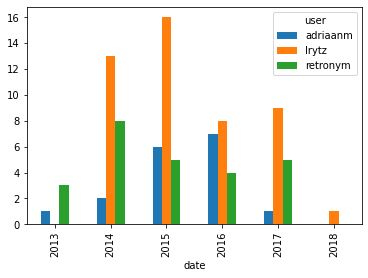

In [13]:
authors = ['retronym', 'adriaanm', 'lrytz']
file = 'src/compiler/scala/tools/nsc/backend/jvm/BCodeHelpers.scala'

# Select the pull requests submitted by the authors, from the `data` DataFrame
by_author = data[data['user'].isin(authors)]

# Select the pull requests that affect the file
by_file = by_author[by_author['file']==file]

# Group and count the number of PRs done by each user each year
grouped = by_file.groupby(['user', by_file['date'].dt.year]).count()['pid'].reset_index()
grouped.head(1)
# Transform the data into a wide format
by_file_wide = grouped.pivot_table(index ='date', columns = 'user', values = 'pid', fill_value=0)

# Plot the results
by_file_wide.plot(kind='bar')